In [2]:
from gammapy_bkg2 import *
from gammapy.maps import MapAxis, MapCoord
from gammapy.datasets import (MapDataset, FluxPointsDataset)
from gammapy.makers import (MapDatasetMaker, SafeMaskMaker, DatasetsMaker, FoVBackgroundMaker, RingBackgroundMaker)
from gammapy.estimators import (ExcessMapEstimator, FluxPointsEstimator)
import yaml

In [3]:
# load in dl3 datastore
ds = DataStore.from_dir('/nevis/tehanu/data/st3624/software/gammapywork/dl3_fullenclosure_moderate2tel/dl3/')

In [23]:
# loads in json file that was prepared with prepare_run_dict.py
srcinfo = load_src_info('CTA1')
len(srcinfo) # should equal length of your runlist

268

In [24]:
# can preview individual run information:
srcinfo[0]

{'run_id': 53346,
 'source_id': 'CTA 1',
 'epoch': 'na',
 'wobble': 0.7,
 'duration': 1203.0,
 'elevation': 48.453227956763754,
 'azimuth': 4.729282730703579,
 'current': 3.949348697394791}

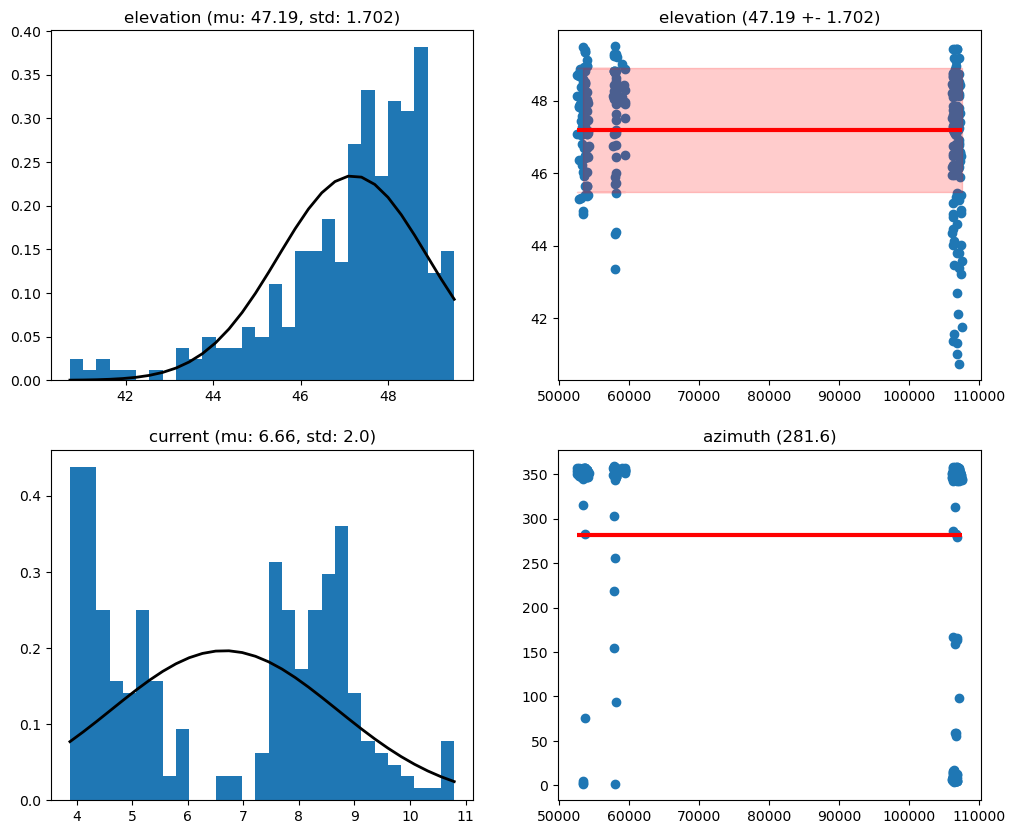

In [25]:
# get an overview of run info:
plot_runs_info(srcinfo)

In [26]:
# retrieve observations from datastore
srcobs = get_available_obs(ds, [run['run_id'] for run in srcinfo])

<SkyCoord (ICRS): (ra, dec) in deg
    (359.28625932, 72.769475)>


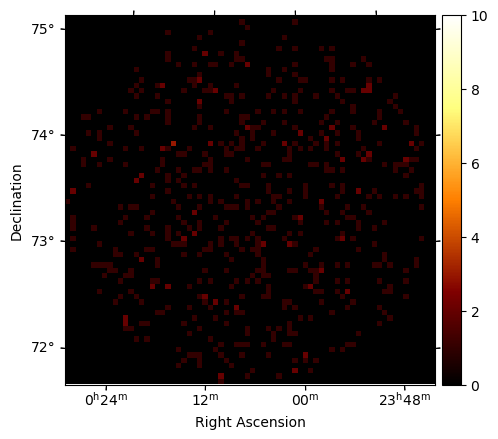

In [27]:
# print RA and Dec for a particular run
print(srcobs[0].meta.pointing.radec_mean)

# plot skymap of counts for a particular run
plot_obs(srcobs[1], add_cbar=True, vmax=10)

In [28]:
# import generated bkg from Jooyun's walkthrough onto observations
from gammapy.irf import Background3D
bkgrate = fits.open('CTA1.bkg')
bkgrate = Background3D.from_hdulist(bkgrate)
for idx, obs in tqdm(enumerate(srcobs)):
    srcobs[idx] = obs.copy(in_memory=True, events=select_gammas(obs), bkg=bkgrate)

268it [00:27,  9.85it/s]


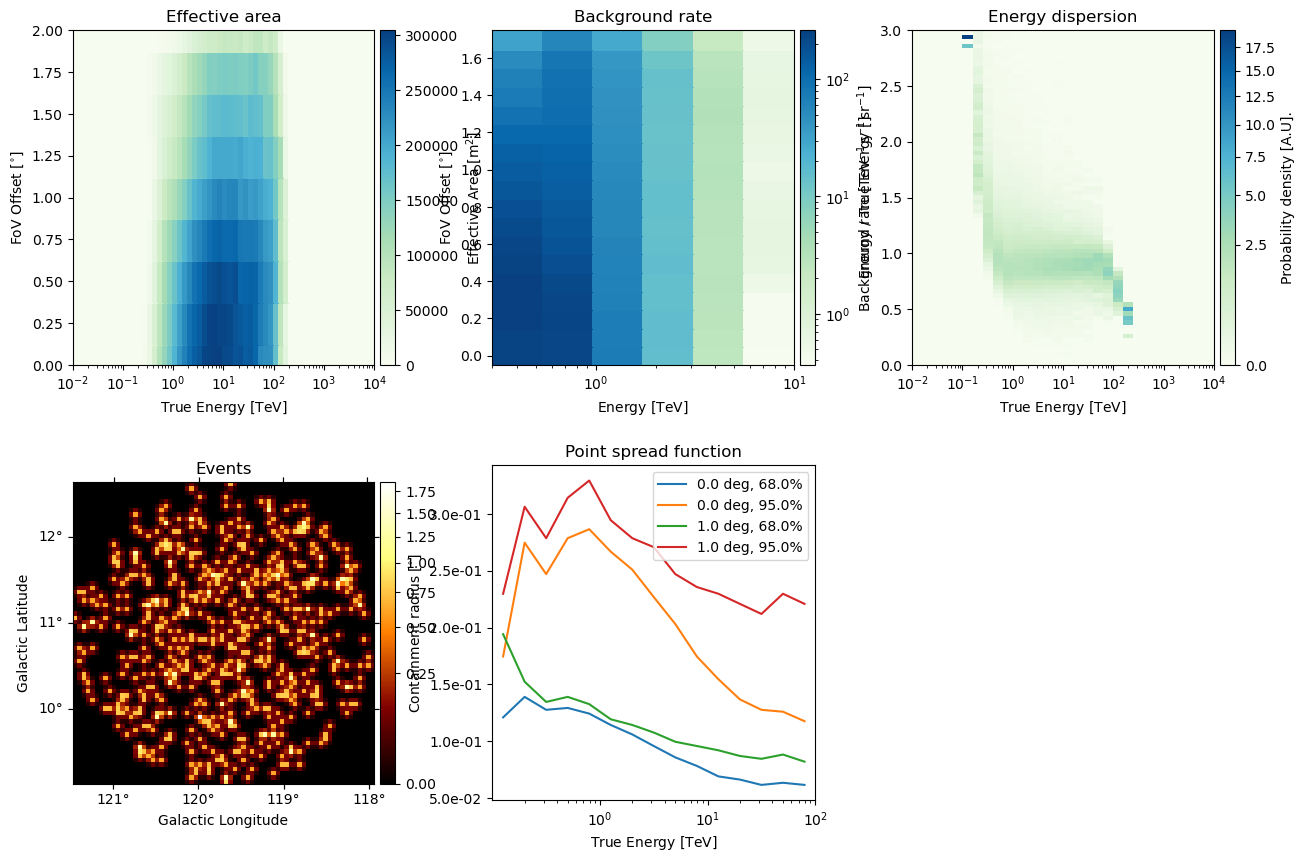

In [29]:
# peek at updated runs
srcobs[1].peek()

In [30]:
# save target sky direction
skydir = srcobs[6].target_radec # different from radec_mean; this is the target radec
print(skydir)

# reduce exposure ~20 hrs - increase stat uncertainty > sys bias in bg
# go back to RBM
# matrix method? 

<SkyCoord (ICRS): (ra, dec) in deg
    (1.65000386, 72.78334438)>


In [31]:
# load in config file, set desired exclusion radius
with open(os.environ['VTS_GP']+'/analysis_config.yml', 'r') as f:
    config = yaml.safe_load(f)
config

{'parallel_njobs': 10,
 'theta': 0.5,
 'exclusion_radius': 0.5,
 'offset_max': 1.5,
 'aeff_max': 10,
 'mimic_data': {'az_thresh': 45},
 'energy_binning': {'energy_lo': 0.3, 'energy_hi': 10, 'energy_bins': 6},
 'acceptance': {'hour': 100, 'binsz': 0.1, 'width': 3.5},
 'skymap': {'binsz': 0.05, 'width': 3.5}}

In [32]:
# create map axis
energy_binning = config['energy_binning']
energy_axis = MapAxis.from_energy_bounds(
    energy_binning['energy_lo']*u.TeV, energy_binning['energy_hi']*u.TeV, energy_binning['energy_bins'])

# prepare Geom object and exclusion mask (source exclusion r = 0.4, star r = 0.3 by default)
geom = WcsGeom.create(
    binsz=config['skymap']['binsz'], frame='icrs', axes=[energy_axis], skydir=skydir, width=config['skymap']['width'])
exclusion_mask_1d = prepare_mask(geom, skydir)

<WCSAxes: >

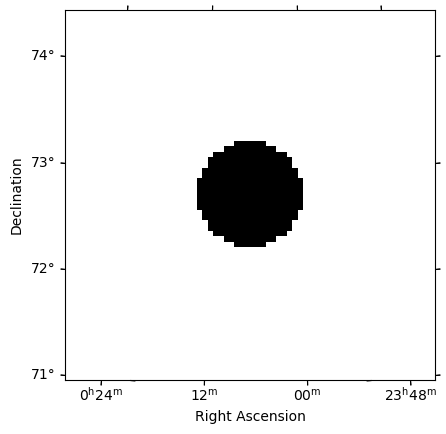

In [33]:
# prepare Geom object and exclusion mask without the energy axis for 2D (imaging) analysis. 
geom_image = geom.to_image().to_cube([energy_axis.squash()])

# PSRJ0007+7303 location
psrdir =  SkyCoord(1.7570833333, 73.703074, frame="icrs", unit="deg")

# create exclusion mask centered at pulsar location
exclusion_mask_2d = prepare_mask(geom_image, psrdir, r_src=config['exclusion_radius'])
exclusion_mask_2d.plot()

In [34]:
map_dataset_maker = MapDatasetMaker()
safe_mask_maker = SafeMaskMaker(methods=['aeff-max','offset-max'],
                                aeff_percent=config['aeff_max'], offset_max=config['offset_max']*u.deg)
datasets_maker = DatasetsMaker([map_dataset_maker, safe_mask_maker],
                               stack_datasets=False, n_jobs=config['parallel_njobs'],
                               cutout_mode='trim', cutout_width=config['offset_max']*2*u.deg)

In [44]:
energy_axis_true = srcobs[0].edisp.axes['energy_true']

In [45]:
stacked = MapDataset.create(geom, energy_axis_true=energy_axis_true, name='stacked')
datasets = datasets_maker.run(stacked, srcobs)

KeyboardInterrupt: 

In [ ]:
fov_bkg_maker = FoVBackgroundMaker(method='scale', exclusion_mask=exclusion_mask_1d)
for data in tqdm(datasets):
    dataset = fov_bkg_maker.run(data)
    stacked.stack(dataset)

100%|██████████| 268/268 [00:13<00:00, 20.45it/s]


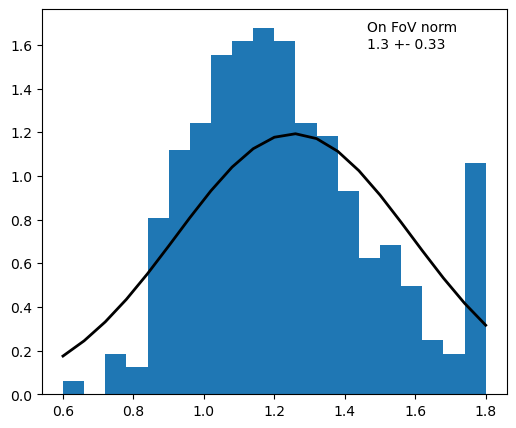

In [ ]:
plot_fov([dataset.models[0].spectral_model.norm.value for dataset in datasets], 'On')

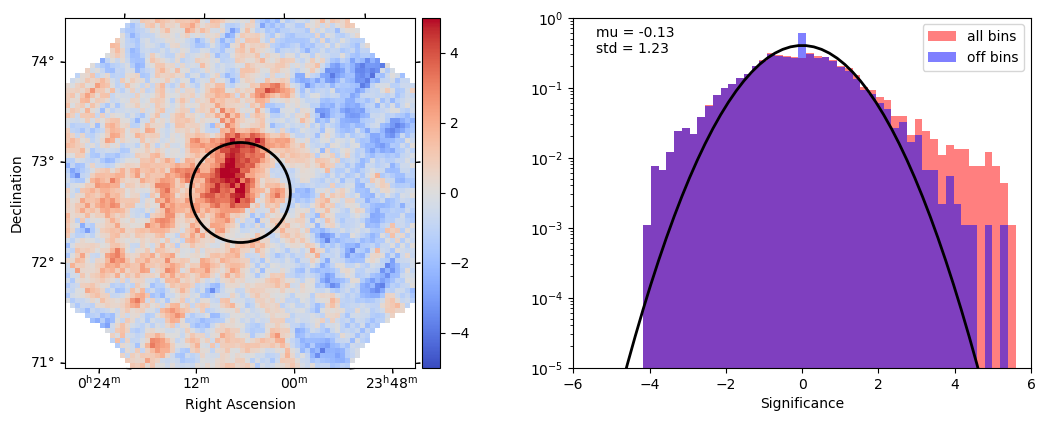

In [ ]:
estimator = ExcessMapEstimator(correlation_radius=0.1*u.deg, correlate_off=False)
lima_maps = estimator.run(stacked)
# lima_maps.list
plot_sig(lima_maps['sqrt_ts'], exclusion_mask_2d, 0.5*u.deg)

In [46]:
# Select mimic data adding up to the same exposure as the on runs.
# These runs are saved in the 1st entry of the registry of "mimic" object.
# Mimic runs are selected from the extragalactic runs that were not used for background generation.
# Same criteria as selecting off runs are applied.
eginfo = load_eg_info(oa=False, na=False)
ds_hdu=DataStore.from_dir('/nevis/tehanu/data/st3624/software/gammapywork/dl3_fullenclosure_moderate2tel/dl3/')
mimic = MimicDatasetMaker(ds_hdu, srcinfo, eginfo, az_thresh=45)
mimic.find_mimic_runs()

100%|██████████| 268/268 [00:02<00:00, 128.57it/s]


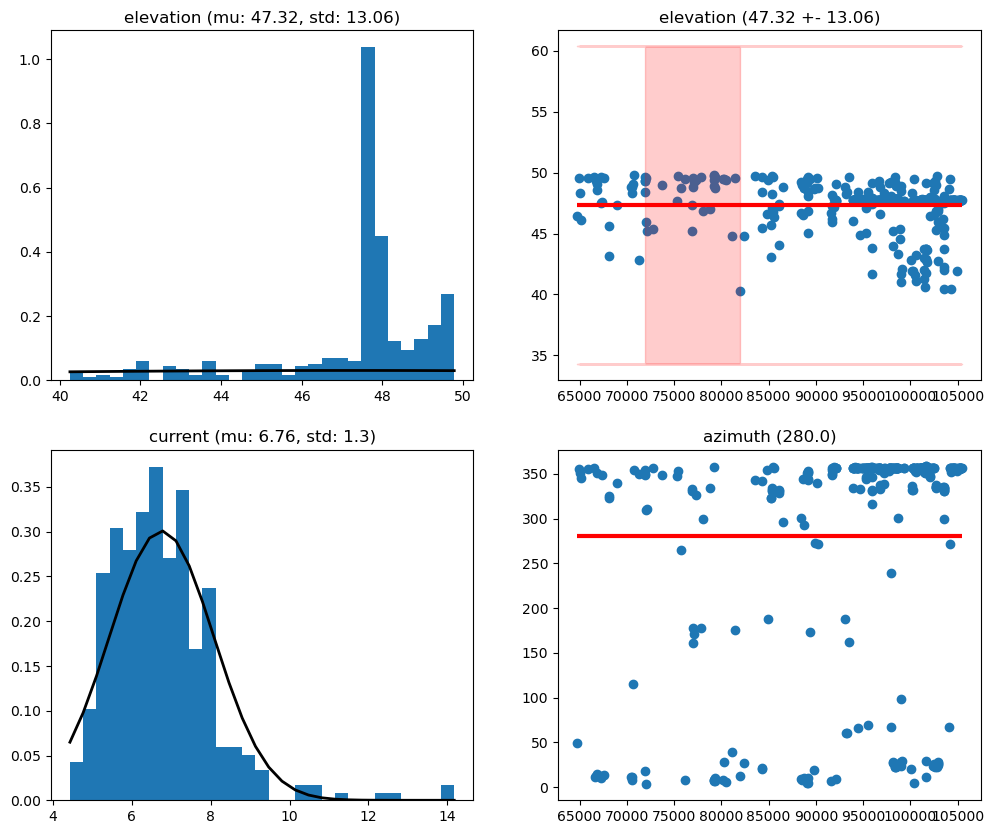

In [49]:
# The elevation and azimuth distribution of mimic runs closely follow those of the on runs.
plot_runs_info(mimic.mimic_datasets[0]['information'])

In [51]:
# Empty the field and shift it as if each mimic run was taken at the same pointing as the corresponding on run.
# These runs are saved in the 1st entry of the registry of "mimic" object.
mimic.run_blank_sky(0)
mimic.run_shifted_sky(0) # matches wobble

352it [00:32, 10.77it/s]
Observation with obs_id 53377 already belongs to Observations.
Observation with obs_id 53380 already belongs to Observations.
Observation with obs_id 53382 already belongs to Observations.
Observation with obs_id 53478 already belongs to Observations.
Observation with obs_id 53507 already belongs to Observations.
Observation with obs_id 53605 already belongs to Observations.
Observation with obs_id 53756 already belongs to Observations.
Observation with obs_id 53971 already belongs to Observations.
Observation with obs_id 54028 already belongs to Observations.
Observation with obs_id 54041 already belongs to Observations.
Observation with obs_id 54112 already belongs to Observations.
Observation with obs_id 54170 already belongs to Observations.
Observation with obs_id 54204 already belongs to Observations.
Observation with obs_id 58983 already belongs to Observations.
Observation with obs_id 59363 already belongs to Observations.
Observation with obs_id 59365 

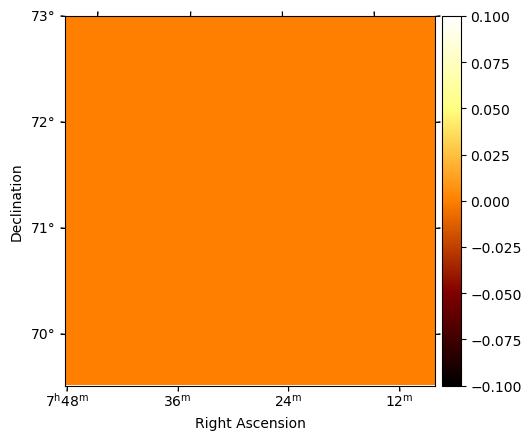

In [52]:
plot_obs(mimic.mimic_datasets[0]['observations'][0], add_cbar=True)

In [ ]:
# Load the background onto the mimic observations.
for idx, obs in tqdm(enumerate(mimic.mimic_datasets[0]['observations'])):
    mimic.mimic_datasets[0]['observations'][idx] = obs.copy(
        in_memory=True, events=select_gammas(obs), bkg=bkgrate)

IndexError: list index out of range

In [59]:
# One can repeat the same analysis steps as the on runs for the mimic runs.
stacked = MapDataset.create(geom, energy_axis_true=energy_axis_true, name='stacked')
datasets = datasets_maker.run(stacked, mimic.mimic_datasets[0]['observations'])

RuntimeError: Execution of a sub-process failed

In [55]:
fov_bkg_maker = FoVBackgroundMaker(method='scale', exclusion_mask=exclusion_mask_1d)
for data in tqdm(datasets):
    dataset = fov_bkg_maker.run(data)
    stacked.stack(dataset)

100%|██████████| 268/268 [00:11<00:00, 23.76it/s]


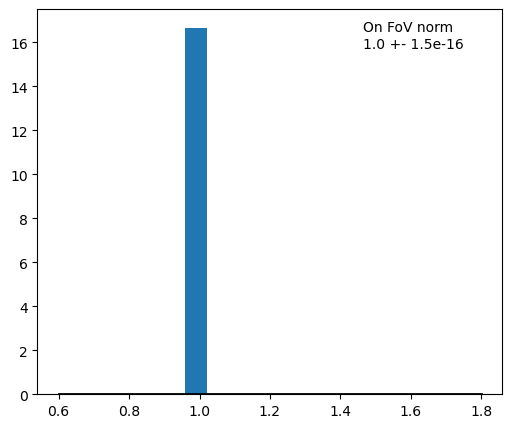

In [56]:
plot_fov([dataset.models[0].spectral_model.norm.value for dataset in datasets], 'On')

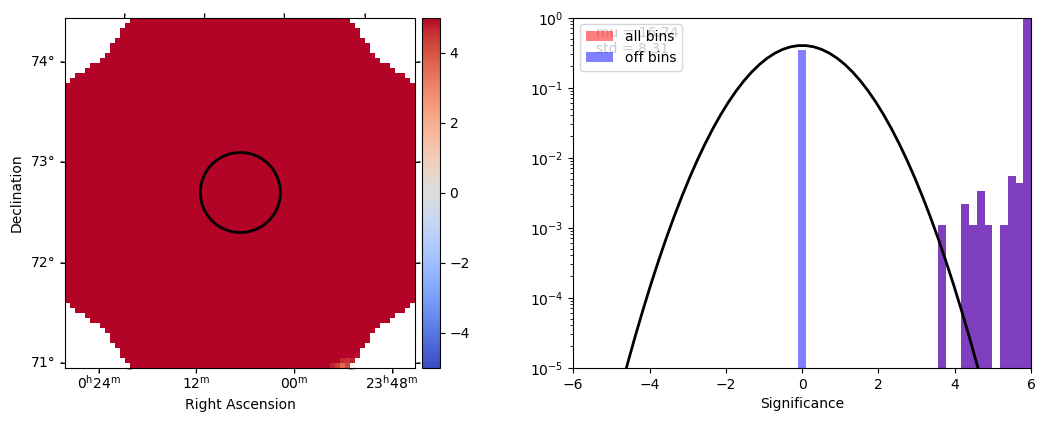

In [57]:
# The field is fairly flat, meaning the background estimation is good.
estimator = ExcessMapEstimator(correlation_radius=config['theta']*u.deg, correlate_off=False)
lima_maps = estimator.run(stacked)
plot_sig(lima_maps['sqrt_ts'], exclusion_mask_2d, 0.4*u.deg)